In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import hazelbean as hb
L = hb.get_logger()

import seaborn as sns
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt

# Load dataset

In [54]:
L.info('Loading data')
baseline_df = pd.read_csv('../IPBES project/intermediate/baseline_regression_data.csv')
L.info('Data loaded')
#baseline_df = baseline_df.drop(['Unnamed: 0'], axis=1)

Loading data
Data loaded


In [55]:
#Merge with nan_mask.csv
nan_df = pd.read_csv('../IPBES project/intermediate/nan_mask.csv',names=['Pixel#','nan_mask'])
B_df = baseline_df.merge(right=nan_df,how='outer',left_on='Unnamed: 0',right_on='Pixel#')

In [56]:
baseline_df = B_df.drop(['Unnamed: 0','Pixel#'], axis=1)

In [42]:
crops_df = pd.read_csv('../IPBES project/intermediate/crop_types_regression_data.csv')
print('Crops_df',
      '# pixels (rows): {}'.format(crops_df.shape[0]),
      '# features (cols-2): {}'.format(crops_df.shape[1]-2),
      '','Crops_df is just baseline_df w/o columns \'calories_per_cell\' and \'GDP 2000\'',
      sep="\n")

Crops_df
# pixels (rows): 2205072
# features (cols-2): 13

Crops_df is just baseline_df w/o columns 'calories_per_cell' and 'GDP 2000'


# Dataset exploration

In [7]:
print('Baseline_df',
      '# pixels (rows): {}'.format(baseline_df.shape[0]),
      '# features: {}'.format(baseline_df.shape[1]-1),
      '',
      'Features:',str(baseline_df.columns),
      '',
      '% Pixels with 0 ag: {:.1%}'.format(baseline_df[baseline_df['calories_per_cell']==0].shape[0]/baseline_df.shape[0]),
      sep="\n")

Baseline_df
# pixels (rows): 2205072
# features: 15

Features:
Index(['calories_per_cell', 'precip', 'temperature', 'gdp_2000',
       'minutes_to_market', 'workability', 'toxicity', 'rooting_conditions',
       'protected_areas', 'oxygen_availability', 'nutrient_retention',
       'nutrient_availability', 'excess_salts', 'gdp_gecon', 'slope',
       'altitude'],
      dtype='object')

% Pixels with 0 ag: 58.3%


## Nan mask

What is nan_mask? When nan_mask == 0: 96% of calories_per_cell values are 0. Let's assume nan_mask therefore means oceans pixels. 4% Error due to pixel size

In [34]:
baseline_df[baseline_df['nan_mask']==0]['calories_per_cell'].describe()

count    6.360980e+05
mean     8.575707e+07
std      2.085394e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.127693e+11
Name: calories_per_cell, dtype: float64

In [41]:
baseline_df[baseline_df['nan_mask']==0]['calories_per_cell'].quantile(0.96)

0.0

In [35]:
baseline_df[baseline_df['nan_mask']!=0]['calories_per_cell'].describe()

count    1.568974e+06
mean     7.253942e+09
std      2.022878e+10
min      0.000000e+00
25%      0.000000e+00
50%      1.345320e+08
75%      4.485239e+09
max      6.815759e+11
Name: calories_per_cell, dtype: float64

##### From now on, we'll therefore screen to look only at pixels when nan_mask ≠ 0

In [57]:
baseline_df = baseline_df[baseline_df['nan_mask']!=0]

## Distribution of calories_per_cell 

In [43]:
baseline_df['calories_per_cell'].describe()

count    1.568974e+06
mean     7.253942e+09
std      2.022878e+10
min      0.000000e+00
25%      0.000000e+00
50%      1.345320e+08
75%      4.485239e+09
max      6.815759e+11
Name: calories_per_cell, dtype: float64

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


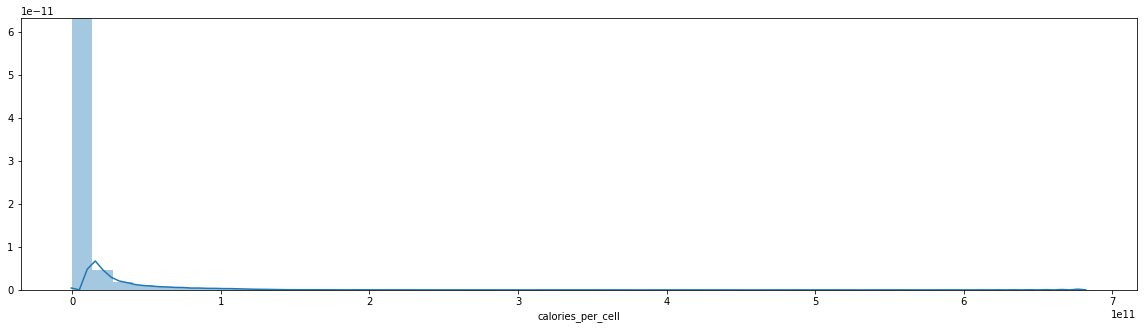

In [45]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(baseline_df['calories_per_cell'],ax=ax)

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


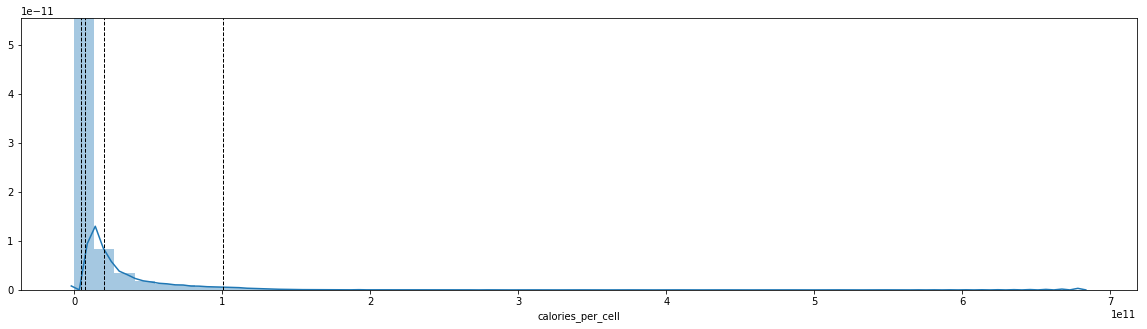

In [46]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(baseline_df[baseline_df['calories_per_cell']!=0]['calories_per_cell'],ax=ax)

#Lines at mean, 75%, 90%, and 99%
plt.axvline(baseline_df['calories_per_cell'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(baseline_df['calories_per_cell'].quantile(0.75), color='k', linestyle='dashed', linewidth=1)
plt.axvline(baseline_df['calories_per_cell'].quantile(0.9), color='k', linestyle='dashed', linewidth=1)
plt.axvline(baseline_df['calories_per_cell'].quantile(0.99), color='k', linestyle='dashed', linewidth=1)

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


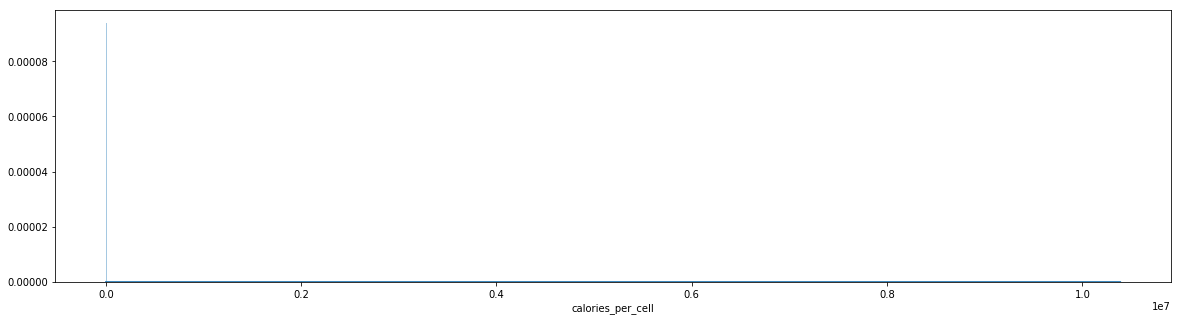

In [21]:
#Remove top 1% of baseline_df['calories_per_cell'] (outliers?)

fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(baseline_df[baseline_df['calories_per_cell']<baseline_df['calories_per_cell'].quantile(0.6)]['calories_per_cell'],ax=ax,bins=1000)


In [12]:
baseline_df['calories_per_cell'].quantile(0.9)

13453749513.77103

In [47]:
only_ag = baseline_df[baseline_df['calories_per_cell']!=0]

## Normalization

In [58]:


scaler = MinMaxScaler()

#scaled_subset_df = pd.DataFrame(scaler.fit_transform(subset_df.T), columns=subset_df.T.columns)
##Q: This normalizes the columns. Is it what I want?

scaled = pd.DataFrame(scaler.fit_transform(baseline_df), columns=baseline_df.columns)
##Q: This normalizes the rows. Is it what I want?


## Subset
Representative (?) sample for faster computation

In [59]:
subset = scaled.sample(frac=0.01, replace=False, weights=None, random_state=None, axis=0)

In [60]:
baseline_df = subset

## Visualizations

In [61]:
baseline_df = baseline_df.sort_values(by=['calories_per_cell'])


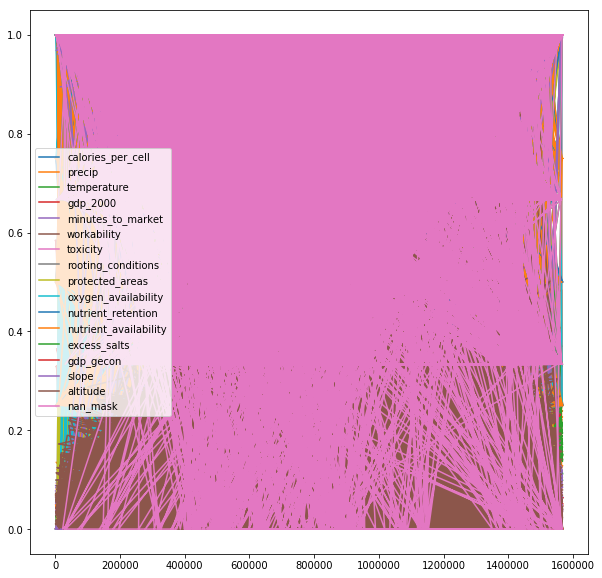

In [64]:
baseline_df.plot(figsize=(10,10))

### Calories_per_cell relationships

In [89]:
features_list = ['precip', 'temperature', 'gdp_2000','minutes_to_market',
                 'workability', 'toxicity', 'rooting_conditions','protected_areas',
                 'oxygen_availability', 'nutrient_retention','nutrient_availability', 'excess_salts', 
                 'gdp_gecon', 'slope','altitude','nan_mask']

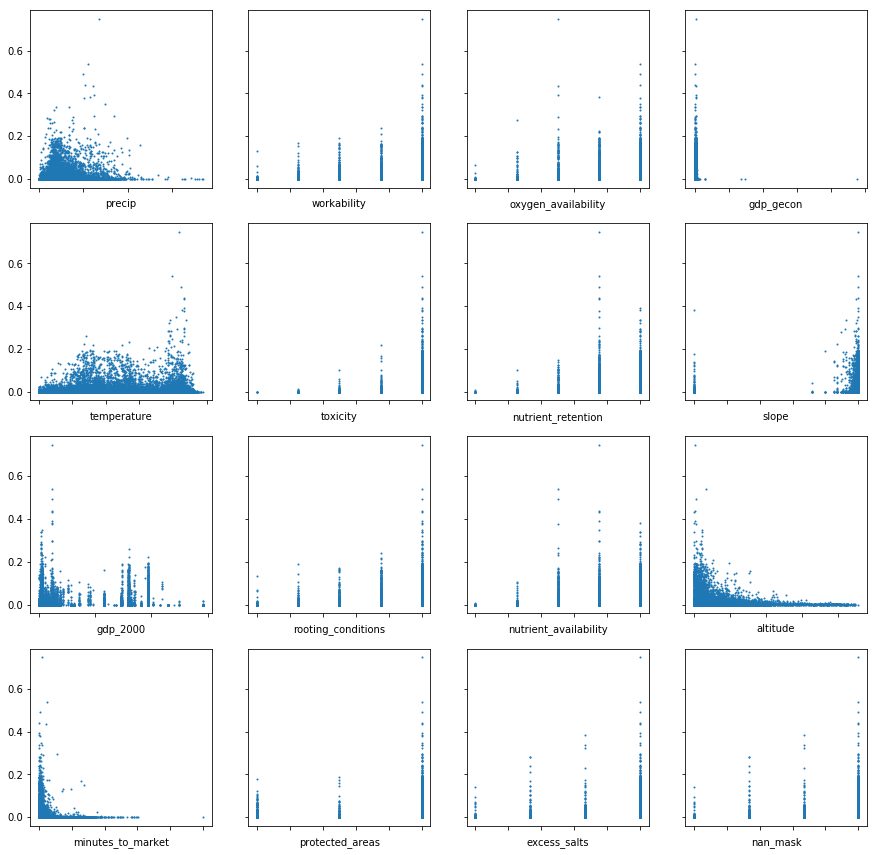

In [92]:
fig,axes = plt.subplots(4, 4, sharey=True,figsize=(15,15))

i =0
j =0
for var in features_list:

    axes[i,j].scatter(data= baseline_df,x=var, y='calories_per_cell',s=1);
    axes[i,j].set_xlabel(var);
    axes[i,j].set_xticklabels([]);

    if i < 3:
        i+=1
    else:
        i=0
        j+=1

##### Relationship with categorical feature (to do with climate zone)

In [ ]:
#box plot overallqual/saleprice
var = 'climatezone'
data = pd.concat([df_train['calories_per_cell'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='calories_per_cell', data=data)
fig.axis(ymin=0, ymax=800000);

### Correlation matrix

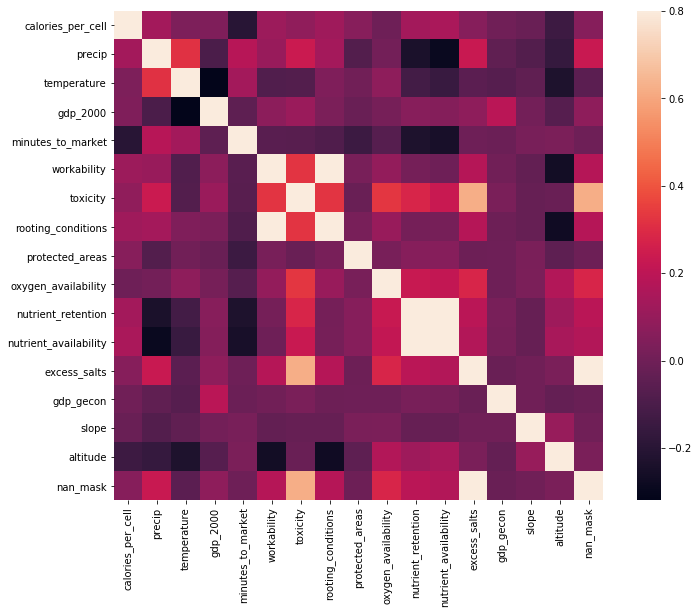

In [67]:
corrmat = baseline_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

* 'nutrient retention' and 'nutrient availability' redundant features (corr=0.87)
* 

In [68]:
baseline_df.corr(method='pearson', min_periods=1)

,calories_per_cell,precip,temperature,gdp_2000,minutes_to_market,workability,toxicity,rooting_conditions,protected_areas,oxygen_availability,nutrient_retention,nutrient_availability,excess_salts,gdp_gecon,slope,altitude,nan_mask
calories_per_cell,1.000000,0.131158,0.036231,0.040191,-0.197098,0.114709,0.086120,0.123074,0.062785,-0.001244,0.133642,0.150869,0.057272,0.000748,-0.016146,-0.137495,0.057272
precip,0.131158,1.000000,0.317782,-0.099420,0.185597,0.106688,0.236717,0.136011,-0.075035,0.009362,-0.239673,-0.289955,0.235731,-0.041228,-0.076620,-0.161395,0.235731
temperature,0.036231,0.317782,1.000000,-0.319273,0.132374,-0.079534,-0.078342,0.041727,0.007914,0.080316,-0.120894,-0.150056,-0.054947,-0.068837,-0.039485,-0.227952,-0.054947
gdp_2000,0.040191,-0.099420,-0.319273,1.000000,-0.048031,0.076182,0.113278,0.032737,-0.013414,0.018149,0.064591,0.055665,0.081776,0.193374,0.012254,-0.067244,0.081776
minutes_to_market,-0.197098,0.185597,0.132374,-0.048031,1.000000,-0.058383,-0.063138,-0.086285,-0.142194,-0.068238,-0.229118,-0.248457,-0.000935,-0.009931,0.023311,0.034083,-0.000935
workability,0.114709,0.106688,-0.079534,0.076182,-0.058383,1.000000,0.325593,0.858885,0.023161,0.093915,0.015277,-0.000308,0.180991,0.008251,-0.031378,-0.265758,0.180991
toxicity,0.086120,0.236717,-0.078342,0.113278,-0.063138,0.325593,1.000000,0.324286,-0.014415,0.330215,0.284066,0.231825,0.621017,0.027011,-0.023532,-0.016429,0.621017
rooting_conditions,0.123074,0.136011,0.041727,0.032737,-0.086285,0.858885,0.324286,1.000000,0.025800,0.106990,0.014280,0.018790,0.179529,-0.005672,-0.025923,-0.271510,0.179529
protected_areas,0.062785,-0.075035,0.007914,-0.013414,-0.142194,0.023161,-0.014415,0.025800,1.000000,0.023905,0.060357,0.057888,-0.007909,-0.002642,0.029931,-0.044148,-0.007909
oxygen_availability,-0.001244,0.009362,0.080316,0.018149,-0.068238,0.093915,0.330215,0.106990,0.023905,1.000000,0.228060,0.215021,0.282287,-0.000460,0.032227,0.173110,0.282287


In [66]:
baseline_df

,calories_per_cell,precip,temperature,gdp_2000,minutes_to_market,workability,toxicity,rooting_conditions,protected_areas,oxygen_availability,nutrient_retention,nutrient_availability,excess_salts,gdp_gecon,slope,altitude,nan_mask
951379,0.000000,0.005318,0.863057,0.002364,0.187845,0.50,0.50,0.50,1.0,0.50,0.50,0.25,0.333333,0.000021,0.992356,0.075236,0.333333
776408,0.000000,0.001806,0.796178,0.023954,0.055329,0.00,0.25,0.00,1.0,0.25,0.25,0.25,0.000000,0.000227,0.998212,0.061820,0.000000
488854,0.000000,0.079161,0.000000,0.000000,0.038343,0.75,1.00,0.50,1.0,1.00,1.00,1.00,1.000000,0.000054,0.999774,0.251632,1.000000
1550581,0.000000,0.026287,0.471338,0.051115,0.036336,1.00,1.00,1.00,1.0,1.00,1.00,0.75,0.333333,0.000271,0.993888,0.022843,0.333333
59114,0.000000,0.068426,0.041401,0.583757,0.009747,0.75,1.00,0.75,1.0,1.00,0.50,0.50,1.000000,0.001300,0.999225,0.115120,1.000000
1186200,0.000000,0.140664,0.863057,0.041526,0.009102,0.25,1.00,0.25,0.5,1.00,0.50,0.50,1.000000,0.000058,0.998047,0.009246,1.000000
725365,0.000000,0.013043,0.691083,0.015109,0.024511,0.75,0.75,0.75,1.0,1.00,1.00,1.00,1.000000,0.000093,0.999733,0.103517,1.000000
27924,0.000000,0.152503,0.117834,0.459226,0.026088,1.00,1.00,0.75,1.0,1.00,1.00,1.00,1.000000,0.001124,0.999620,0.051487,1.000000
1397053,0.000000,0.069630,0.694268,0.292124,0.015624,0.50,1.00,1.00,1.0,0.75,1.00,1.00,1.000000,0.001018,0.999124,0.044235,1.000000
580696,0.000000,0.021571,0.509554,0.013294,0.054899,0.50,0.50,0.50,1.0,0.50,0.25,0.25,0.333333,0.000000,0.997467,0.059463,0.333333


In [ ]:
plt.figure();

In [22]:
baseline_df[baseline_df['calories_per_cell']==0].shape

(1286532, 17)

In [23]:
1286532/2205072

0.5834421733167896

In [7]:
### - - - - - - - - -
### Train/test split
### - - - - - - - - -

x = baseline_df.drop(['calories_per_cell'], axis=1)
y = baseline_df['calories_per_cell']

X_train, X_test, y_train, y_test = train_test_split(x, y)

In [8]:
### - - - - - - - - -
### Feature normalization
### - - - - - - - - -
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
##  KNeighborsRegressor (scaled)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_score= knn.score(X_test_scaled, y_test)
print('KNN Regressor with ',5,' nearest neighbors - - - ')
print('KNN Score on training set: ', knn.score(X_train_scaled, y_train))
print('KNN Score on test set: ', knn_score)

KNN Regressor with  5  nearest neighbors - - - 
KNN Score on training set:  1.0
KNN Score on test set:  1.0


In [15]:
L.info('LinearRegression')

linreg = LinearRegression().fit(X_train, y_train)
print('R-squared score (training): {:.3f}'
      .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linreg.score(X_test, y_test)))

LinearRegression


R-squared score (training): 1.000
R-squared score (test): 1.000


In [16]:
L.info('LinearRegression (scaled)')

linreg = LinearRegression().fit(X_train_scaled, y_train)
print('R-squared score (training): {:.3f}'
      .format(linreg.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linreg.score(X_test_scaled, y_test)))

LinearRegression (scaled)


R-squared score (training): 1.000
R-squared score (test): 1.000


In [14]:
L.info('Ridge Regression ')
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train, y_train)
print('R-squared score (training): {:.3f}'
      .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linridge.score(X_test, y_test)))

Ridge Regression 


R-squared score (training): 1.000
R-squared score (test): 1.000


In [17]:
L.info('Polynomial Regression ')
from sklearn.linear_model import LinearRegression
linlasso = Lasso(alpha=2.0, max_iter=10000).fit(X_train_scaled, y_train)
print('R-squared score (training): {:.3f}'
      .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
      .format(linlasso.score(X_test_scaled, y_test)))

Polynomial Regression 


NameError: name 'Lasso' is not defined

In [ ]:
## XG Boost ?

## SVM